# Scale Y U V
Cette version traite la partie du filtre YUV avec un IP qui fait la conversion "Scale".

In [46]:
from pynq import Overlay

overlay = Overlay('scale_3dma.bit')

In [47]:
# Display the names of the overlay IP blocks
print('IP blocks :', list(overlay.ip_dict.keys()))

IP blocks : ['axi_dma_0', 'axi_dma_1', 'axi_dma_2', 'scale_y_0', 'scale_y_1', 'scale_y_2', 'processing_system7_0']


In [48]:
scale_ip0 = overlay.scale_y_0
scale_ip1 = overlay.scale_y_1
scale_ip2 = overlay.scale_y_2

dma0 = overlay.axi_dma_0
dma0_send = overlay.axi_dma_0.sendchannel
dma0_recv = overlay.axi_dma_0.recvchannel

dma1 = overlay.axi_dma_1
dma1_send = overlay.axi_dma_1.sendchannel
dma1_recv = overlay.axi_dma_1.recvchannel

dma2 = overlay.axi_dma_2
dma2_send = overlay.axi_dma_2.sendchannel
dma2_recv = overlay.axi_dma_2.recvchannel

scale_ip0.write(0x10, 128) 
scale_ip1.write(0x10, 128) 
scale_ip2.write(0x10, 128) 

In [49]:
CONTROL_REGISTER = 0x0
scale_ip0.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0

scale_ip1.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0

scale_ip2.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0

## Import functions

In [96]:
# !pip install numpy
import numpy as np
# !pip install opencv-python
import cv2
# !pip install matplotlib
import matplotlib
# !pip install rawpy
# import rawpy

from pynq import allocate
import numpy as np
import time

width = 200
height = 272

In [97]:
def image_read(fname):
    fp = open(fname,'r') 
    tmp = int(fp.readline())
    width = tmp
    tmp = int(fp.readline()) 
    height = tmp;
    in_width  = width
    in_height = height 
    in_ch1 = [[0 for y in range(height)] for x in range(width)]
    in_ch2 = [[0 for y in range(height)] for x in range(width)]
    in_ch3 = [[0 for y in range(height)] for x in range(width)]
    for x in range(width): 
        for y in range(height):
            tmp = int(fp.readline())
            in_ch1[x][y] = int(tmp)
            tmp = int(fp.readline())
            in_ch2[x][y] = tmp 
            tmp = int(fp.readline())
            in_ch3[x][y] =  tmp
    fp.close() 
    return in_width, in_height, in_ch1, in_ch2, in_ch3

In [98]:
def image_write(out_width, out_height, out_ch1, out_ch2, out_ch3, fname):
    fp = open(fname,'w')
    width = out_width   
    fp.write('{}\n'.format(width)); 
    height = out_height  
    fp.write('{}\n'.format(height));
    for x in range(width):   
        for y in range(height):  
            tmp = out_ch1[x][y] 
            fp.write('{}\n'.format(tmp))
            tmp = out_ch2[x][y]  
            fp.write('{}\n'.format(tmp)) 
            tmp = out_ch3[x][y] 
            fp.write('{}\n'.format(tmp))
    fp.close()   # fclose(fp);

In [99]:
def rgb2yuv (in_width, in_height, in_ch1, in_ch2, in_ch3):
    start = time.time()
    Wrgb = [[66, 129,  25],[-38, -74, 112],[122, -94, -18]]
    width = in_width
    height = in_height
    out_width = width     
    out_height = height 
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    for x in range(width):   
        for y in range(height):       
            R = in_ch1[x][y] 
            G = in_ch2[x][y]
            B = in_ch3[x][y] 
            Y = ((Wrgb[0][0] * R + Wrgb[0][1] * G + Wrgb[0][2] * B + 128) >> 8) +  16
            U = ((Wrgb[1][0] * R + Wrgb[1][1] * G + Wrgb[1][2] * B + 128) >> 8) + 128
            V = ((Wrgb[2][0] * R + Wrgb[2][1] * G + Wrgb[2][2] * B + 128) >> 8) + 128 
            out_ch1[x][y] = Y  
            out_ch2[x][y] = U   
            out_ch3[x][y] = V 
    end = time.time()
    print('Soft version "RGB2YUV":')
    time_compute_version = get_duration(start, end)
    return out_width, out_height, out_ch1, out_ch2, out_ch3

In [111]:
def yuv2rgb (in_width, in_height, in_ch1, in_ch2, in_ch3):
    Wyuv = [[298, 0, 409],[298, -100, -208],[298, 516, 0]]
    width = in_width
    height = in_height
    out_width = width  
    out_height = height 
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    start = time.time()
    for x in range(width):  
        for y in range(height):   
            Y = in_ch1[x][y]   
            U = in_ch2[x][y]   
            V = in_ch3[x][y]  
            C = Y - 16  
            D = U - 128
            E = V - 128
            R = ( Wyuv[0][0] * C                  + Wyuv[0][2] * E + 128) >> 8 
            if R > 255:
                R = 255
            if R < 0:
                R = 0
            G = ( Wyuv[1][0] * C + Wyuv[1][1] * D + Wyuv[1][2] * E + 128) >> 8
            if G > 255:
                G = 255
            if G < 0:
                G = 0
            B = ( Wyuv[2][0] * C + Wyuv[2][1] * D                  + 128) >> 8
            if B > 255:
                B = 255
            if B < 0:
                B = 0
            out_ch1[x][y] = R  
            out_ch2[x][y] = G   
            out_ch3[x][y] = B  
    end = time.time()
    print('Soft version "YUV2RGB":')
    time_compute_version = get_duration(start, end)
    return out_width, out_height, out_ch1, out_ch2, out_ch3

In [128]:
def dma_transfer(in_ch0, in_ch1, in_ch2, out_ch0, out_ch1, out_ch2, data_size):
    input_buffer0 = allocate(shape=(data_size,), dtype=int)
    output_buffer0 = allocate(shape=(data_size,), dtype=int)
    input_buffer1 = allocate(shape=(data_size,), dtype=int)
    output_buffer1 = allocate(shape=(data_size,), dtype=int)
    input_buffer2 = allocate(shape=(data_size,), dtype=int)
    output_buffer2 = allocate(shape=(data_size,), dtype=int)
    for x in range (width):
        for y in range (height):
            input_buffer0[x*height + y] = in_ch0[x][y]
            input_buffer1[x*height + y] = in_ch1[x][y]
            input_buffer2[x*height + y] = in_ch2[x][y]
    start = time.time()
    dma0_send.transfer(input_buffer0)
    dma1_send.transfer(input_buffer1)
    dma2_send.transfer(input_buffer2)
    dma0_recv.transfer(output_buffer0)
    dma1_recv.transfer(output_buffer1)
    dma2_recv.transfer(output_buffer2)
    dma0_send.wait()
    dma0_recv.wait()
    dma1_send.wait()
    dma1_recv.wait()
    dma2_send.wait()
    dma2_recv.wait()
    dma0_send.transfer(input_buffer0)
    dma1_send.transfer(input_buffer1)
    dma2_send.transfer(input_buffer2)
    dma0_recv.transfer(output_buffer0)
    dma1_recv.transfer(output_buffer1)
    dma2_recv.transfer(output_buffer2)
    dma0_send.wait()
    dma0_recv.wait()
    dma1_send.wait()
    dma1_recv.wait()
    dma2_send.wait()
    dma2_recv.wait()
    end = time.time()
    print('Hard version "scale":')
    time_compute_version = get_duration(start, end)
    for x in range (width):
        for y in range (height):
            out_ch0[x][y] = output_buffer0[x*height + y]   
            out_ch1[x][y] = output_buffer1[x*height + y]   
            out_ch2[x][y] = output_buffer2[x*height + y]   
    del input_buffer0, output_buffer0, input_buffer1, output_buffer1, input_buffer2, output_buffer2

In [102]:
def scale_dma(in_width, in_height, in_ch1, in_ch2, in_ch3, Y_scale, U_scale, V_scale):
    width = in_width
    height = in_height
    out_width = width
    out_height = height
    data_size = width * height
    scale_ip0.write(0x10, Y_scale) 
    scale_ip1.write(0x10, U_scale) 
    scale_ip2.write(0x10, V_scale) 
    out_ch1 = [[0 for y in range(height)] for x in range(width)]
    out_ch2 = [[0 for y in range(height)] for x in range(width)]
    out_ch3 = [[0 for y in range(height)] for x in range(width)]
    dma_transfer(in_ch1, in_ch2, in_ch3, out_ch1, out_ch2, out_ch3, data_size)
    print('transfer done')
    return out_width, out_height, out_ch1, out_ch2, out_ch3

In [103]:
def process_image(in_width, in_height, in_ch1, in_ch2, in_ch3, Y_scale, U_scale, V_scale):
    
    yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3 = rgb2yuv(in_width, in_height, in_ch1, in_ch2, in_ch3)
    
    
    scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 = \
        scale_dma( yuv_width, yuv_height, yuv_ch1, yuv_ch2, yuv_ch3, Y_scale, U_scale, V_scale )
        
    out_width, out_height, out_ch1, out_ch2, out_ch3 = \
        yuv2rgb(scale_width, scale_height, scale_ch1, scale_ch2, scale_ch3 )
    
    return out_width, out_height, out_ch1, out_ch2, out_ch3

In [104]:
import numpy as np

# transform raw data to RGB raw image

def raw_rgb_image(in_width, in_height, in_ch1, in_ch2, in_ch3):
    
    rgb = np.ndarray((in_width,in_height,3), np.int16)  
    rgb[:,:,0] = in_ch1
    rgb[:,:,1] = in_ch2
    rgb[:,:,2] = in_ch3
    
    return rgb

In [105]:
def dat2jpg(file_data, file_jpg):
    tmp_width, tmp_height, tmp_ch1, tmp_ch2, tmp_ch3 = image_read(file_data)
    new_rgb = raw_rgb_image(tmp_width, tmp_height, tmp_ch1, tmp_ch2, tmp_ch3)
    cv2.imwrite(file_jpg, new_rgb) 

In [106]:
def display_img(file_jpg):
    image = Image.open(file_jpg)
    display(image)

In [107]:
#Compute the duration between "start" and "end" to get the function execution time
import time
def get_duration(start, end):
    delta_t = round((end - start) * 1000, 1)
    print('Duration : {0} ms'.format(delta_t))
    return delta_t

## Main function

INPUT:


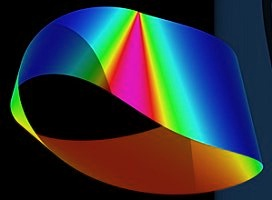

Soft version "RGB2YUV":
Duration : 943.4 ms
Hard version "scale":
Duration : 6.7 ms
transfer done
Soft version "YUV2RGB":
Duration : 5513.5 ms
OUTPUT:


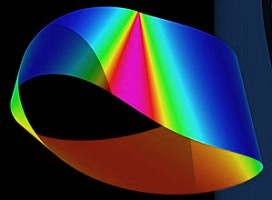

In [129]:
import cv2
import numpy as np
from PIL import Image, ImageOps



rgb_width, rgb_height, rgb_ch1, rgb_ch2, rgb_ch3 = image_read('input.dat')

print('INPUT:')
dat2jpg('input.dat','input.jpg')
display_img('input.jpg')

restore_width, restore_height, restore_ch1, restore_ch2, restore_ch3 = process_image(rgb_width, 
                                                                                     rgb_height, 
                                                                                     rgb_ch1, 
                                                                                     rgb_ch2, 
                                                                                     rgb_ch3, 
                                                                                     128, 128, 128)

image_write(restore_width, restore_height, restore_ch1, restore_ch2, restore_ch3,'fh_output.dat')

print('OUTPUT:')
dat2jpg('fh_output.dat','fh_output.jpg')
display_img('fh_output.jpg')

In [114]:
import difflib
# my_diff: compare image text files 
# int ret = system("diff --brief -w test_data/output.dat test_data/output.golden.dat"); 
 
def my_diff(original_file,version_file):
    ret = 0
    with open(version_file, 'r') as fp1:
        with open(original_file, 'r') as fp0:
            fp0lines = fp0.readlines() 
            fp1lines = fp1.readlines() 
            first = False
            count = 0
            for x in range(len(fp0lines)):
                if fp0lines[x] != fp1lines[x]: 
                    count = count + 1
                    if not first:  
                        print("first diff at (", x,')',int(fp0lines[x]),int(fp1lines[x]))
                        first = True
            ret = count 
            print('{} {}'.format('output.golden.dat','fh_output.dat'),'| errors =', ret,'/',len(fp0lines))
    return ret

Right output:


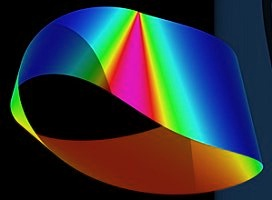

My output:


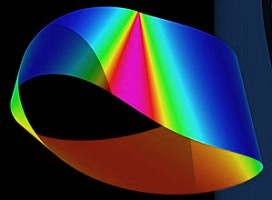

output.golden.dat fh_output.dat | errors = 0 / 163202


In [115]:
import cv2
import numpy as np
from PIL import Image, ImageOps

print('Right output:')
display_img('output.golden.jpg')

print('My output:')
display_img('fh_output.jpg')

ret = my_diff('fh_output.dat','output.dat')